# Normal Distibution

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 12)

In [3]:
import warnings
warnings.simplefilter('ignore')

## Avarage Temperature

In [4]:
train_path = 'https://raw.githubusercontent.com/mirpulatov/CS_MSU/main/Course%20Work/data/tavg/train_1d.csv'
test_path = 'https://raw.githubusercontent.com/mirpulatov/CS_MSU/main/Course%20Work/data/tavg/test_1d.csv'
full_path = 'https://raw.githubusercontent.com/mirpulatov/CS_MSU/main/Course%20Work/data/tavg/full_1d.csv'
train_data = pd.read_csv(train_path, parse_dates = ['date'], index_col = ['date'], dayfirst = True)
test_data = pd.read_csv(test_path, parse_dates = ['date'], index_col = ['date'], dayfirst = True)
full_data = pd.read_csv(full_path, parse_dates = ['date'], index_col = ['date'], dayfirst = True)
train_data = train_data.asfreq('d')
test_data = test_data.asfreq('d')
full_data = full_data.asfreq('d')

In [5]:
res = train_data.groupby(by=[train_data.index.month, train_data.index.day]).mean()
year = res[res.index != (2, 29)].tavg.to_numpy()
leap_year = res.tavg.to_numpy()

In [6]:
train_data_2011 = train_data[train_data.index.year == 2011]
train_data_2012 = train_data[train_data.index.year == 2012]
train_data_2013 = train_data[train_data.index.year == 2013]
train_data_2014 = train_data[train_data.index.year == 2014]

In [7]:
train_data_2011['noise'] = train_data_2011.tavg - year
train_data_2012['noise'] = train_data_2012.tavg - leap_year
train_data_2013['noise'] = train_data_2013.tavg - year
train_data_2014['noise'] = train_data_2014.tavg - year

train_data_2011['avg'] = year
train_data_2012['avg'] = leap_year
train_data_2013['avg'] = year
train_data_2014['avg'] = year

In [8]:
test_data['y_hat'] = year

In [9]:
noise_data = train_data_2011.append(train_data_2012)
noise_data = noise_data.append(train_data_2013)
noise_data = noise_data.append(train_data_2014)

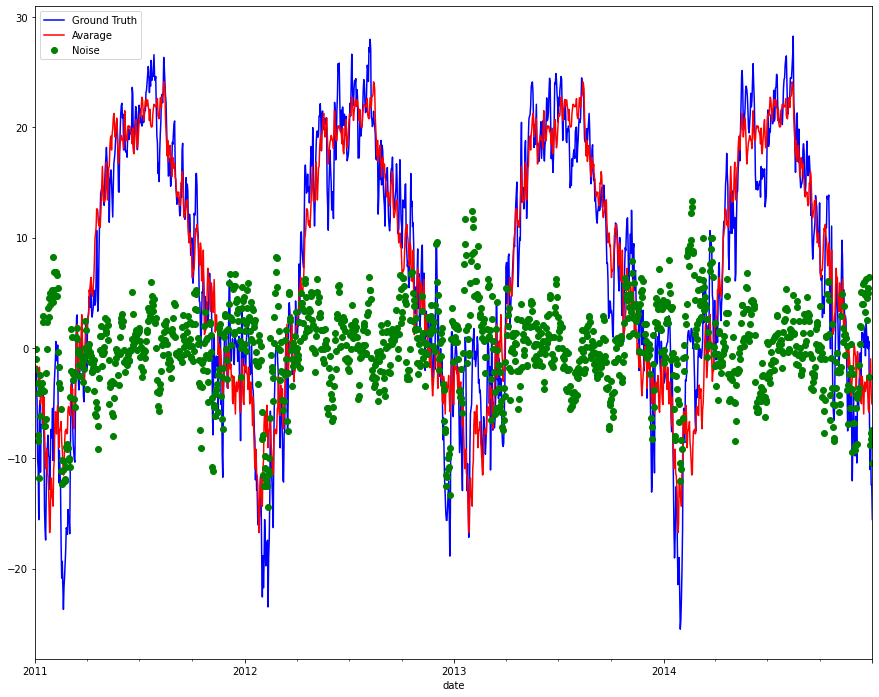

In [10]:
noise_data.tavg.plot(style=['b']);
noise_data.avg.plot(style=['r']);
noise_data.noise.plot(style=['go']);
plt.legend(["Ground Truth", "Avarage", "Noise"]);

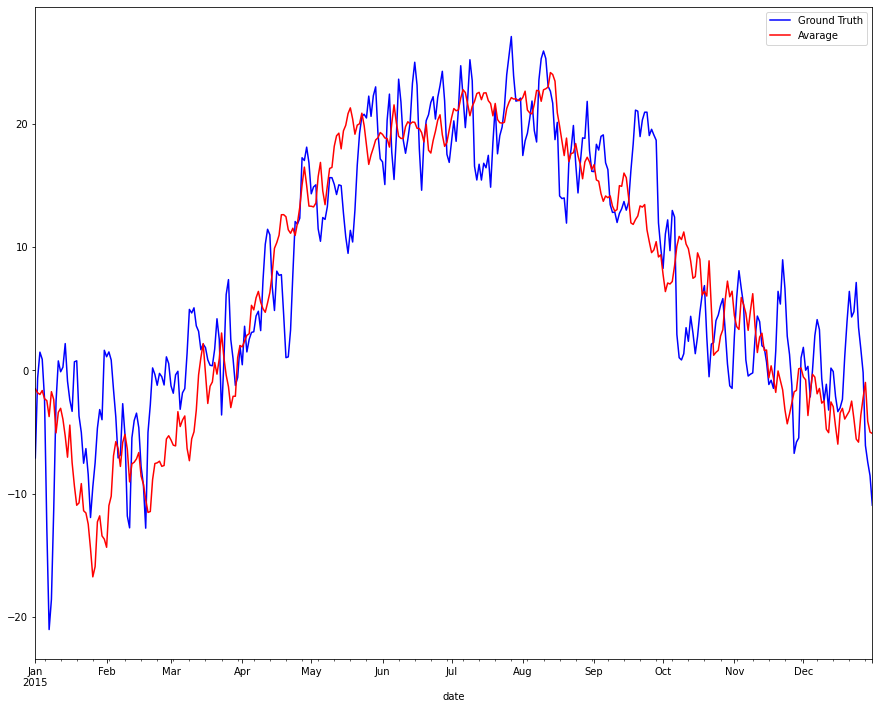

In [11]:
test_data.tavg.plot(style='b');
test_data.y_hat.plot(style='r');
plt.legend(["Ground Truth", "Avarage"]);

In [12]:
print(f"RMSE: {mean_squared_error(test_data.tavg, test_data.y_hat, squared=False)}")

RMSE: 5.091464226039435


In [13]:
import statsmodels.api as sm

Dickey-Fuller test: p=0.000000


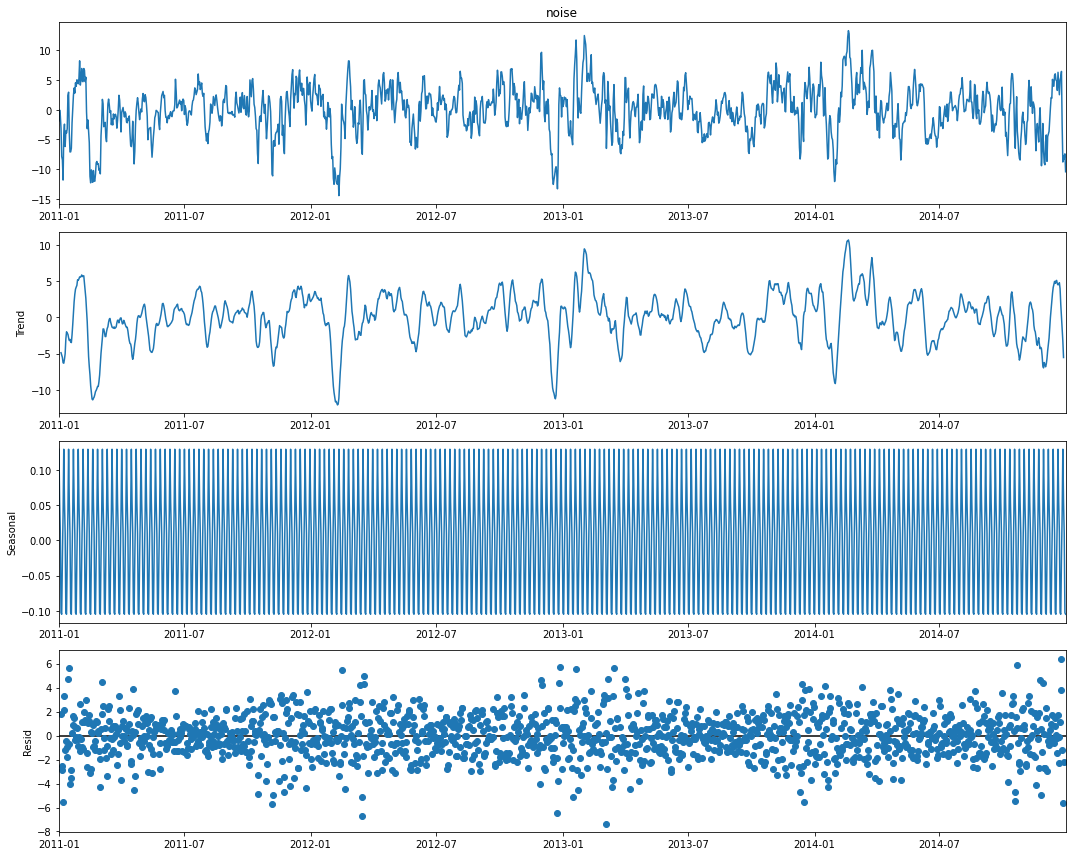

In [14]:
sm.tsa.seasonal_decompose(noise_data.noise).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(noise_data.noise)[1])

In [15]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from tqdm.auto import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)

In [16]:
# one-step sarima forecast
def sarima_forecast(data, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(
        data,
        order=order,
        seasonal_order=sorder,
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    # fit model
    model_fit = model.fit(disp=False)
    return model_fit

In [17]:
# create a set of sarima configs to try
def sarima_configs():
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = [0, 6, 12]
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [18]:
def grid_search(train, test, configs):
    result = {}
    for cfg in tqdm(configs):
        try:
            model = sarima_forecast(
                data=train,
                config=cfg
            )
            preds = model.predict(start=len(train), end=len(train)+len(test)-1)
            result[f'{cfg}'] = mean_squared_error(
                test.to_numpy(),
                preds.to_numpy(),
                squared=False
            )
        except Exception as e:
            continue
    return dict(sorted(result.items(), key=lambda item: item[1]))

In [19]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [20]:
test_data['res'] = test_data.tavg - test_data.y_hat

In [21]:
configs = sarima_configs()
scores = grid_search(noise_data.noise, test_data.res, configs)

  0%|          | 0/3888 [00:00<?, ?it/s]

In [22]:
with open('noise_tavg_params.json', 'w') as fp:
    json.dump(scores, fp)

In [23]:
min(scores, key=scores.get), scores[min(scores, key=scores.get)]

("[(2, 0, 2), (1, 1, 2, 6), 'c']", 4.908193495601324)

In [31]:
noise_data

,tavg,noise,avg
date,,,
2011-01-01,-3.369167,-1.872188,-1.496979
2011-01-02,-1.874167,-0.054583,-1.819583
2011-01-03,-2.973333,-1.020000,-1.953333
2011-01-04,-4.793750,-3.159375,-1.634375
2011-01-05,-10.151250,-7.853542,-2.297708
...,...,...,...
2014-12-27,-11.009583,-8.788750,-2.220833
2014-12-28,-8.670417,-7.692188,-0.978229
2014-12-29,-12.425000,-8.290729,-4.134271


In [32]:
model = sarima_forecast(data=noise_data.noise, config=[(2, 0, 2), (1, 1, 2, 6), 'c'])

In [33]:
preds = model.predict(start=0, end=len(noise_data))

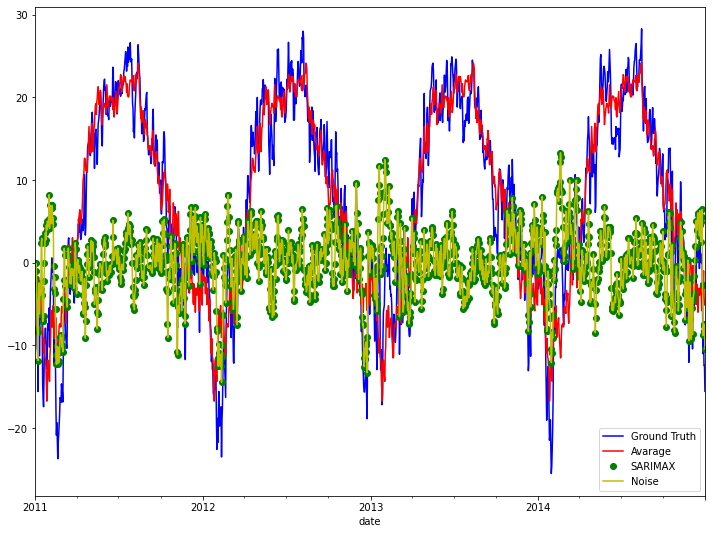

In [35]:
noise_data.tavg.plot(style=['b']);
noise_data.avg.plot(style=['r']);
noise_data.noise.plot(style=['go']);
noise_data.noise.plot(style=['y']);
plt.legend(["Ground Truth", "Avarage", "SARIMAX", "Noise"]);

In [37]:
preds = model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

In [40]:
test_data['SARIMAX'] = preds + year

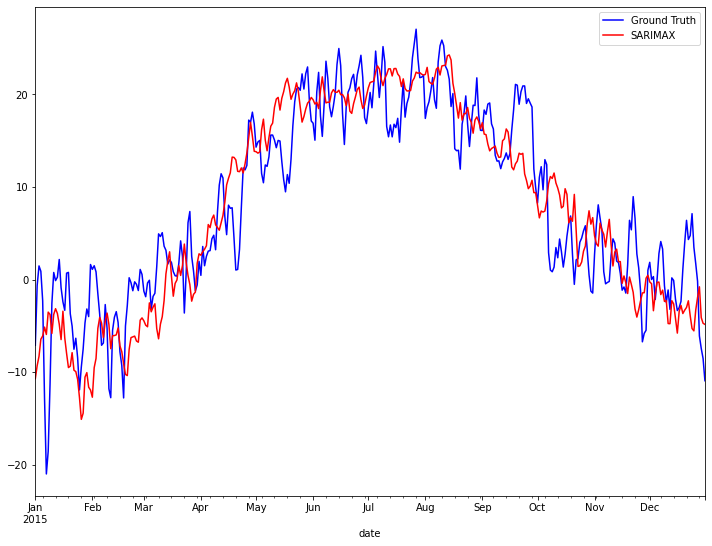

In [42]:
test_data.tavg.plot(style='b');
test_data.SARIMAX.plot(style='r');
plt.legend(["Ground Truth", "SARIMAX"]);

In [43]:
print(f"RMSE: {mean_squared_error(test_data.tavg, test_data.SARIMAX, squared=False)}")

RMSE: 4.908193495601324
